In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

In [2]:
anatree = Anatree("/home/henrique/Documents/cernbox/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k_new.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree
anatree.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet_new',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [3]:
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
showers = anatree.reco_showers
merged = 0

# for i,n in enumerate(nu):
#     df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
#     df = df.collect()
#     if i == 0:
#         merged = df
#     else:
#         merged = pl.concat([merged,df])

In [7]:
df:pl.DataFrame
df = 0
dfnu = nu.filter(pl.col('ccnc_truth')==0).filter(pl.col('nuPDG_truth').abs()==14)
for i,n in enumerate(anatree.nu):
    dfg = geant[i]#.head(1000000)
    dfg = dfg.filter(pl.col('Mother_geant')==0)
    gcc = (
        dfg.join(dfnu.lazy(), left_on=['subrun','event'], right_on=['subrun', 'event'], how='inner')
    )
    gcc = gcc.collect()
    if i == 0:
      df = gcc  
    else:
        df = pl.concat([df,gcc])
        # if i == 1:
        #    break


# df.groupby(['subrun']).agg(pl.col('event').unique().count()).sort(['subrun']).sum()

In [6]:
nu = merge_same_df(anatree.nu)

In [133]:
def create_intervals():
    global Ebins
    intervals = []
    for i, e in enumerate(Ebins[:-1]):
        intervals.append(f'[{e} - {Ebins[i+1]}) GeV')
    return intervals
def plot_by_energy(bins, df:pl.DataFrame, variables, labels, fig=None, columns = 3, show_entries=False, **kwargs):

    global Ebins
    if 'figsize' in kwargs:
        figsize=kwargs.pop('figsize')
    else:
        figsize=(14,10)

    nplots = len(Ebins) - 1
    rows = nplots//columns
    last_empty= False
    if nplots%columns != 0:
        last_empty = True
        rows+=1
    
    if not (isinstance(bins, list)):
        bins = [ bins for _ in range(nplots)]
    


    qc = [] 
    intervals = []
    entries = []
    for i, e in enumerate(Ebins[:-1]):
        qt = df.filter(
            (pl.col('enu_truth') >= e) & (pl.col('enu_truth') < Ebins[i+1])
        ).with_columns(
            counts = pl.col('enu_truth').count()
        )
        qc.append(qt)
        entries.append(qt.head(1)['counts'].to_numpy())
        intervals.append(f'E = [{e} - {Ebins[i+1]}) GeV')
        
    axes=0 
    if fig is None:
        fig, axes = plt.subplots(rows,columns,figsize=figsize)
    else:
        axes = fig.get_axes()

    try:
        axes = axes.flatten()
    except:
        if not isinstance(axes,list):
            axes = [axes]
        else:
            axes = axes

    vbin_centers = [0 for _ in axes]
    vbin_heights = [0 for _ in axes]
        
    for i, (inter,ax) in enumerate(zip(intervals,axes)):
        ax:plt.Axes
        for var,label in zip(variables,labels):
            std=np.std(qc[i][var].to_numpy())
            if show_entries: label = label + f': {entries[i]} events'#; $\sigma$={std:.1f}'
            bin_heights, bin_borders, _ = ax.hist(qc[i][var], bins=bins[i], histtype='step', label=label, density=True);
            bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
            vbin_centers[i] = bin_centers
            vbin_heights[i] = bin_heights
            # ax.set_xlabel(r'$\theta$(degrees) $\equiv$ $\cos^{-1} [\vec{p}_{final} \cdot \vec{p}_{\nu_\mu}/(|\vec{p}_{final}| |\vec{p}_{\nu_\mu}|)]$', fontsize=20)
            ax.set_xlabel(r'$\theta$(degrees)', fontsize=20)
            ax.tick_params(labelsize=18)
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
            legend = ax.legend(frameon=True, title=intervals[i])
            plt.setp(legend.get_title(),fontsize='x-large')
    return fig, vbin_centers, vbin_heights

def get_angle(str_g, str_nu, geant_type='geant'):
    variables = ['x','y','z']
    mom_geant = [str_g + v + '_' + geant_type for v in variables]
    mom_nu = [str_nu+v + '_truth'for v in variables]
    r = pl.col(mom_geant[0])*pl.col(mom_nu[0])
    for mg, mn in zip(mom_geant[1:], mom_nu[1:]):
        r += pl.col(mg)*pl.col(mn)

    # return r
    expr =  (r/pl.col(str_g+'_'+geant_type).abs())
    return pl.when(expr.abs()<1).then(expr.arccos()*180/np.pi).otherwise(expr.round(0).arccos()*180/np.pi)
    return ret.arccos()*180/np.pi
       
def show_credibility(axes, x, y, idx=1, hist_idx = 0, cred = 0.68, draw_lines=True):
    global Ebins
    intervals = create_intervals()

    hist_cred =  get1Dcred(y[idx],cred)
    min_cred = min(hist_cred)
    max_cred = max(hist_cred)
    mode_cred = hist_cred[0]

    ax:plt.Axes
    ax = axes[idx]
    c = ax.patches[hist_idx].get_facecolor()[:-1]
    if draw_lines:
        ax.axvline(x[idx][mode_cred], c='red', linestyle='--', label=fr'MPV: {x[idx][mode_cred]:0.2f}$^\circ$')
        ax.axvline(x[idx][min_cred], c=c, linestyle='--')
        ax.axvline(x[idx][max_cred], c=c, linestyle='--', label=rf'$1\sigma$ (max: {x[idx][max_cred]:0.2f}$^\circ$, min: {x[idx][min_cred]:0.2f}$^\circ$)')
        legend = ax.legend(frameon=True, title=intervals[idx], fontsize=18)
        plt.setp(legend.get_title(),fontsize='large')
    else:
        plt.plot(0,0)
        custom_line = [plt.Line2D([0],[0], c=c, linestyle='--')]
        custom_label = [rf'$1\sigma$ (max: {x[idx][max_cred]:0.2f}$^\circ$, min: {x[idx][min_cred]:0.2f}$^\circ$), MPV: {x[idx][mode_cred]:0.2f}$^\circ$']
        h, l = ax.get_legend_handles_labels()
        h.extend(custom_line)
        l.extend(custom_label)
        ax.legend(h, l, frameon=True, title=intervals[idx])


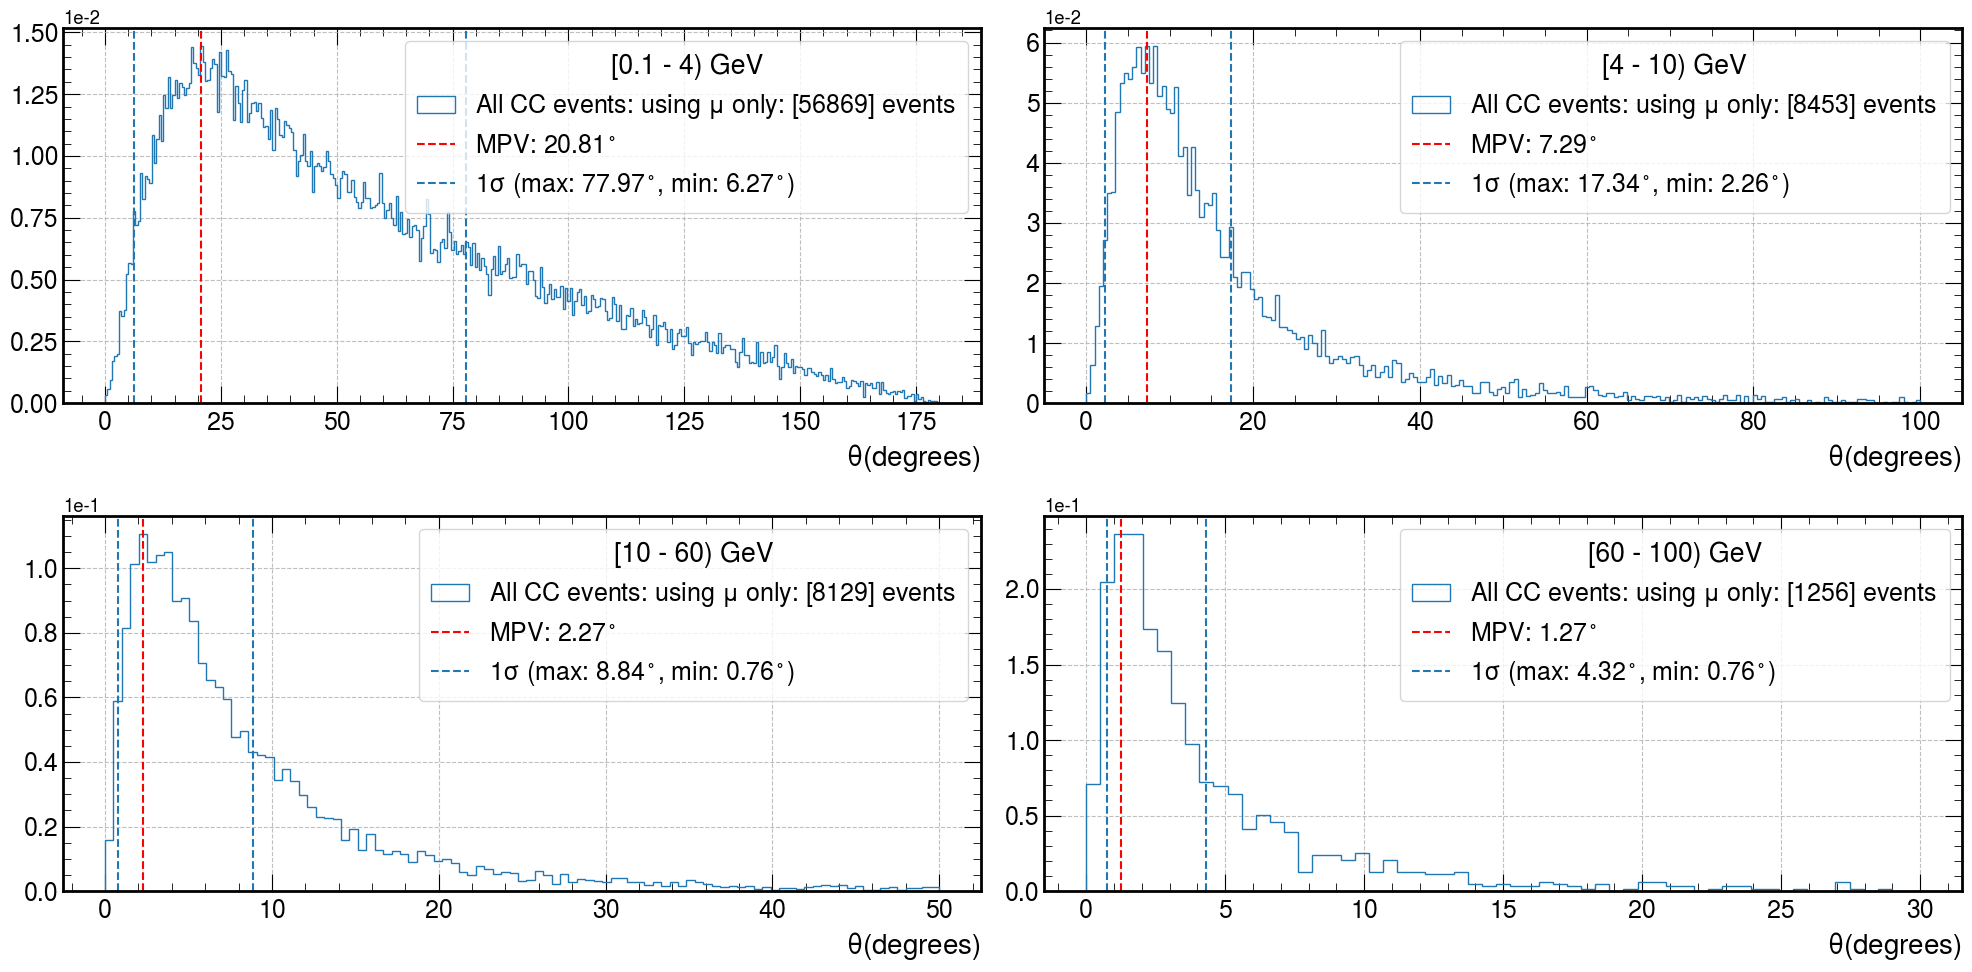

In [176]:
 
q = (
    df.filter(
        (pl.col('ccnc_truth').abs()==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        (pl.col('pdg_geant').abs()==13) & (pl.col('Mother_geant')==0)
    ).with_columns(
        # angle_diff = get_angle('StartP','nu_dcos',geant_type='drifted_geant'),
        angle_diff = get_angle('P','nu_dcos'),
    )
)

q2 = df.groupby(['subrun', 'event']).agg(
    pl.col('nu_dcosx_truth').first().alias('nu_dcostx_truth'),
    pl.col('nu_dcosy_truth').first().alias('nu_dcosty_truth'),
    pl.col('nu_dcosz_truth').first().alias('nu_dcostz_truth'),
    pl.col('enu_truth').first(),
    pl.col('Px_geant').filter(pl.col('pdg_geant').abs()==13).first().alias('Psx_geant'),
    pl.col('Py_geant').filter(pl.col('pdg_geant').abs()==13).first().alias('Psy_geant'),
    pl.col('Pz_geant').filter(pl.col('pdg_geant').abs()==13).first().alias('Psz_geant'),
    pl.col('Px_geant').sum().alias('Ptx_geant'),
    pl.col('Py_geant').sum().alias('Pty_geant'),
    pl.col('Pz_geant').sum().alias('Ptz_geant'),
    pl.col('^P[a-z]_geant$'),
    pl.col('pdg_geant'),
    pl.col('pdg_geant').filter((pl.col('pdg_geant').abs()==13) | (pl.col('pdg_geant').abs()==2212)).alias('pdg_geant_group'),
    
).with_columns(
    pl.col('pdg_geant_group').list.lengths().alias('len_select'),
    pl.col('pdg_geant').list.lengths().alias('len'),
    Pt_geant = (pl.col('Ptx_geant').pow(2) + pl.col('Pty_geant').pow(2) + pl.col('Ptz_geant').pow(2)).sqrt(),
    Ps_geant = (pl.col('Psx_geant').pow(2) + pl.col('Psy_geant').pow(2) + pl.col('Psz_geant').pow(2)).sqrt(),
).filter(( pl.col('len_select')==2 ) & (pl.col('len') == 2))


q_mu_proton = (
    q2.select(
        # angle_diff = get_angle('StartP','nu_dcos',geant_type='drifted_geant'),
        # pl.all(),
        pl.col('enu_truth'),
        angle_diff_s = get_angle('Ps','nu_dcost'),
        angle_diff_t = get_angle('Pt','nu_dcost'),
    )
)
# plt.hist(q['angle_diff'], bins=np.linspace(-20,180,200), histtype='step', label=r'All CC events: using $\mu$ only', density=True);
bins = [np.linspace(0,180,360), np.linspace(0,100,200), np.linspace(0,50,100), np.linspace(0,30,60)]
# bins = np.linspace(0,20,100)
Ebins = [0.1,4,10,60,100]
fig, x, y = plot_by_energy(bins=bins,df=q,variables=['angle_diff'],labels=[r'All CC events: using $\mu$ only'], columns=2, show_entries=True, figsize=(20,10))

show_credibility(fig.axes, x, y, idx=0, hist_idx=0)
show_credibility(fig.axes, x, y, idx=1, hist_idx=0)
show_credibility(fig.axes, x, y, idx=2, hist_idx=0)
show_credibility(fig.axes, x, y, idx=3, hist_idx=0)
# fig, _, _ = plot_by_energy(bins=bins,df=q_mu_proton,variables=['angle_diff_s'],labels=[r'Only $\mu$ + p events: using $\mu$ only'], fig = fig, columns=1, show_entries=True, figsize=(20,14))
# fig, x, y = plot_by_energy(bins=bins,df=q_mu_proton,variables=['angle_diff_t'],labels=[r'Only $\mu$ + p events: using both'], fig = fig, columns=1, show_entries=True, figsize=(20,14))
# fig.get_axes()[1].hist(q_mu_proton['angle_diff_s'], bins=np.linspace(-20,180,200), histtype='step', label=r'Only $\mu$ + p events: using $\mu$ only', density=True);
# plt.hist(q_mu_proton['angle_diff_t'], bins=np.linspace(-20,180,200), histtype='step', label='test', density=True);
# plt.xlabel(r'$\theta$(degrees) $\equiv$ $\cos^{-1} [\vec{p}_{final} \cdot \vec{p}_{\nu_\mu}/(|\vec{p}_{final}| |\vec{p}_{\nu_\mu}|)]$')
# plt.legend()


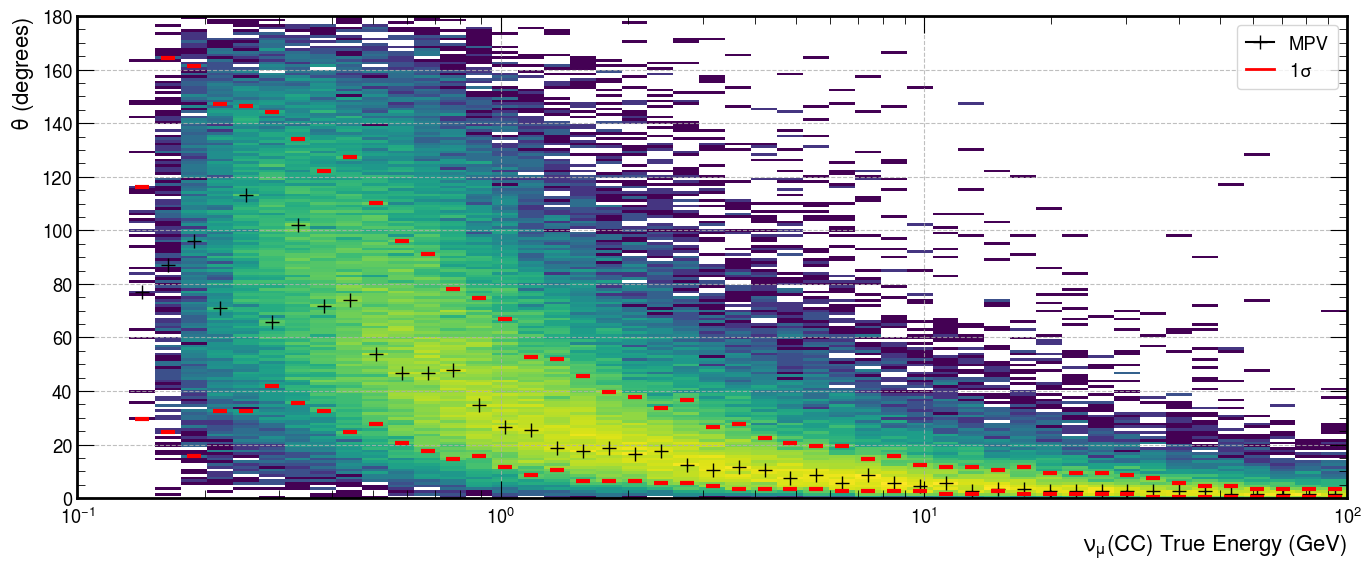

In [142]:
def plot_angle_vs_energy2D(df:pl.DataFrame, binsx, binsy, angle_var):
    plt.hist2d(df['enu_truth'], df[angle_var], bins=[binsx, binsy], norm='log');
    plt.xscale('log')
    from scipy.stats import binned_statistic_2d

    H, edgex, edgey, binnumber = binned_statistic_2d(df['enu_truth'], df[angle_var],None,'count', bins=(binsx,binsy))
    edxwidth = (edgex[1:]-edgex[:-1])/2
    edywidth = (edgey[1:]-edgey[:-1])/2
    edxcenter = edgex[:-1] + edxwidth
    edycenter = edgey[:-1] + edywidth
    for i in range(len(H)):
        if max(H[i,:]) > 1:
            hist_cred =  get1Dcred(H[i,:], 0.68)
            min_cred = 0
            max_cred = 0
            mode_cred = 0
            if len(hist_cred)!=0:
                min_cred = min(hist_cred)
                max_cred = max(hist_cred)
                mode_cred = hist_cred[0]
            plt.plot(edxcenter[i], edycenter[mode_cred], '+', mew=1, markersize=10, color='black')
            plt.plot(edxcenter[i], edycenter[min_cred], '_', mew=3, markersize=10, color='red')
            plt.plot(edxcenter[i], edycenter[max_cred], '_', mew=3, markersize=10, color='red')
        else:
            pass

    custom_label = [
        plt.Line2D([0],[0], color='black',marker='+', markersize=10, mew=1, label='MPV'),
        plt.Line2D([0],[0],lw=2, color='red',  label=r'1$\sigma$'),
        ]
    plt.legend(frameon=True, handles=custom_label)
    plt.xlabel(r'$\nu_\mu$(CC) True Energy (GeV)')
    plt.ylabel(r'$\theta$ (degrees)')

binsx=np.logspace(-1,2, 50)
binsy=np.linspace(0,180, 180)
plot_angle_vs_energy2D(q, binsx, binsy, 'angle_diff')


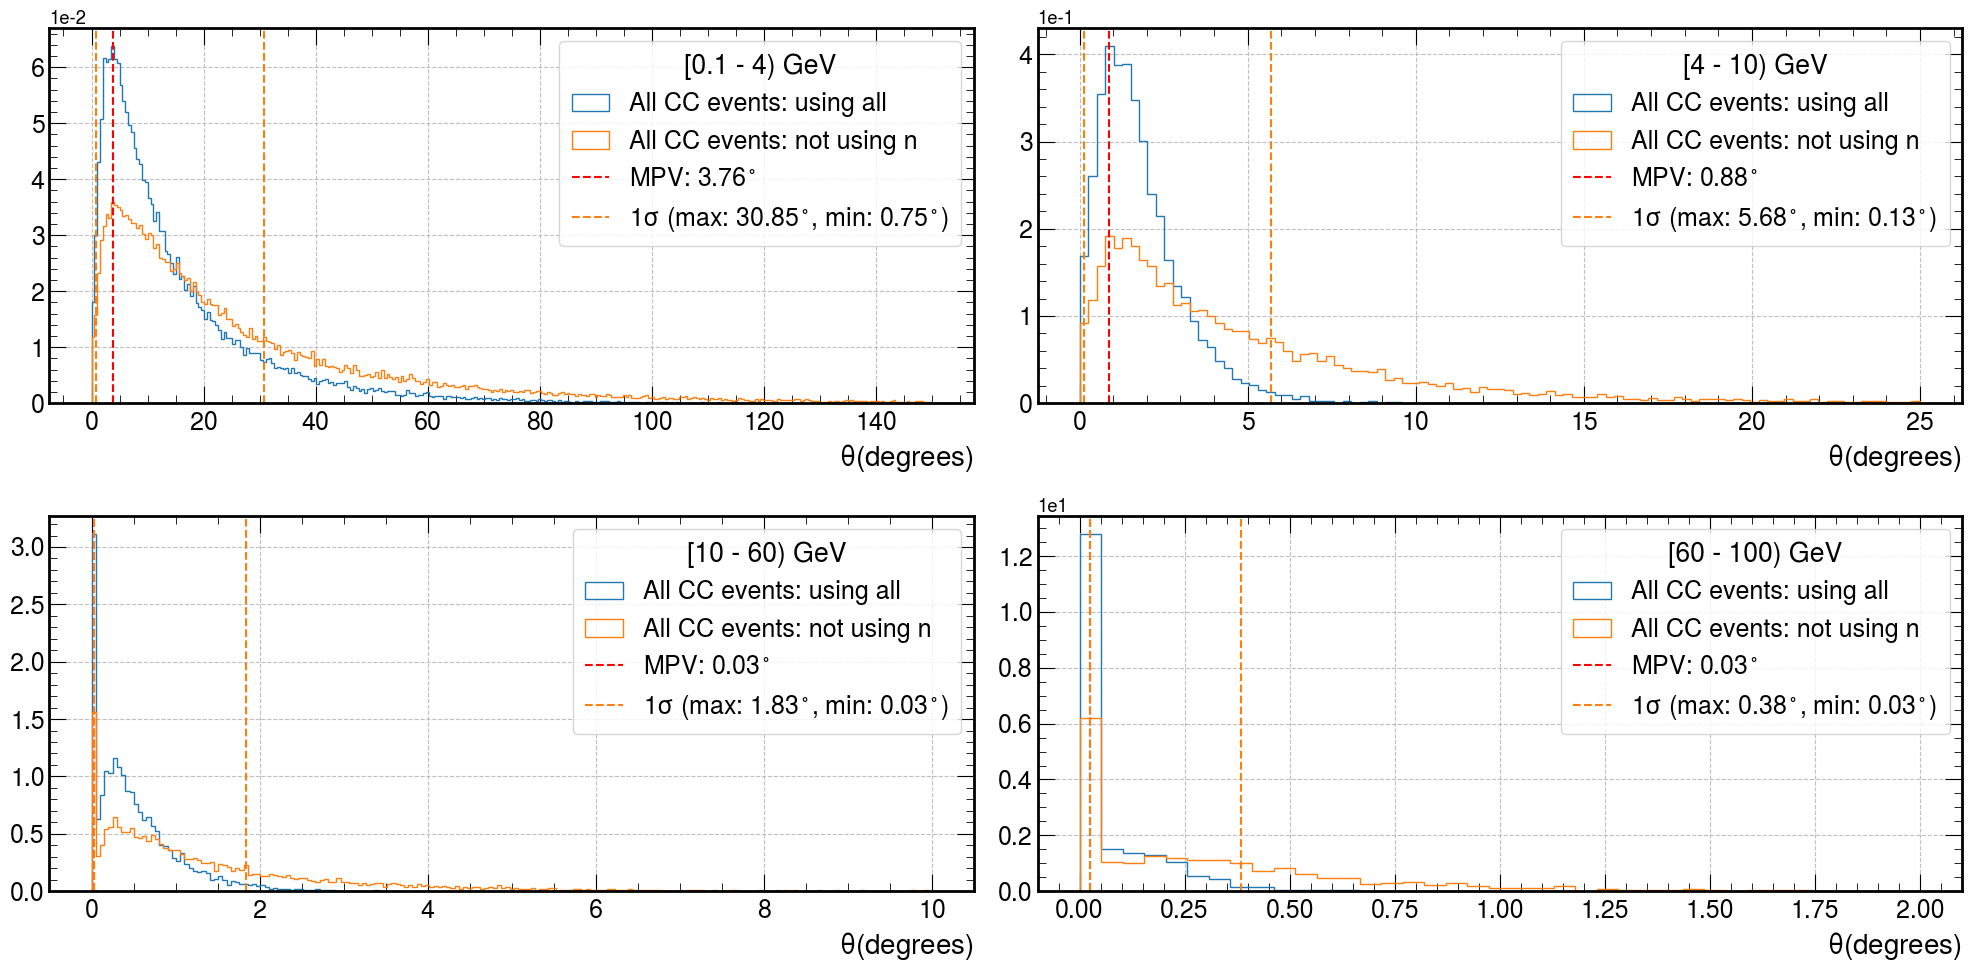

In [103]:
q3 = df.groupby(['subrun', 'event']).agg(
    pl.col('nu_dcosx_truth').first().alias('nu_dcostx_truth'),
    pl.col('nu_dcosy_truth').first().alias('nu_dcosty_truth'),
    pl.col('nu_dcosz_truth').first().alias('nu_dcostz_truth'),
    pl.col('enu_truth').first(),
    pl.col('Px_geant').filter(pl.col('pdg_geant').abs()!=2112).sum().alias('Psx_geant'),
    pl.col('Py_geant').filter(pl.col('pdg_geant').abs()!=2112).sum().alias('Psy_geant'),
    pl.col('Pz_geant').filter(pl.col('pdg_geant').abs()!=2112).sum().alias('Psz_geant'),
    pl.col('Px_geant').sum().alias('Ptx_geant'),
    pl.col('Py_geant').sum().alias('Pty_geant'),
    pl.col('Pz_geant').sum().alias('Ptz_geant'),
    pl.col('^P[a-z]_geant$'),
    pl.col('pdg_geant'),
    pl.col('pdg_geant').alias('pdg_geant_group'),
    
).with_columns(
    pl.col('pdg_geant_group').list.lengths().alias('len_select'),
    pl.col('pdg_geant').list.lengths().alias('len'),
    Pt_geant = (pl.col('Ptx_geant').pow(2) + pl.col('Pty_geant').pow(2) + pl.col('Ptz_geant').pow(2)).sqrt(),
    Ps_geant = (pl.col('Psx_geant').pow(2) + pl.col('Psy_geant').pow(2) + pl.col('Psz_geant').pow(2)).sqrt(),
)

q_all = (
    q3.select(
        pl.col('enu_truth'),
        angle_diff_s = get_angle('Ps','nu_dcost'),
        angle_diff_t = get_angle('Pt','nu_dcost'),
    )
)
Ebins=[0.1,4,10,60,100]
bins = [np.linspace(0,150,300), np.linspace(0,25,100), np.linspace(0,10,200), np.linspace(0,2,40)]
# fig, x0, y0 = plot_by_energy(bins=bins, df=q,variables=['angle_diff'],labels=[r'All CC events: using $\mu$ only'], columns=2, figsize=(20,10))
fig, x2, y2 = plot_by_energy(bins=bins, df=q_all,variables=['angle_diff_t'],labels=[r'All CC events: using all'], columns=2, figsize=(20,10))
fig, x, y = plot_by_energy(bins=bins, df=q_all,variables=['angle_diff_s'],labels=[r'All CC events: not using n'],fig = fig, columns=2, figsize=(20,10))
axes = fig.get_axes()


show_credibility(axes,x,y, idx=0, hist_idx=1)
show_credibility(axes,x,y, idx=1, hist_idx=1)
show_credibility(axes,x,y, idx=2, hist_idx=1)
show_credibility(axes,x,y, idx=3, hist_idx=1)

# for ax in axes:
#     ax.set_yscale('log')
# plt.xlabel(r'$\theta$(degrees) $\equiv$ $\cos^{-1} [\vec{p}_{final} \cdot \vec{p}_{\nu_\mu}/(|\vec{p}_{final}| |\vec{p}_{\nu_\mu}|)]$')
# plt.legend()

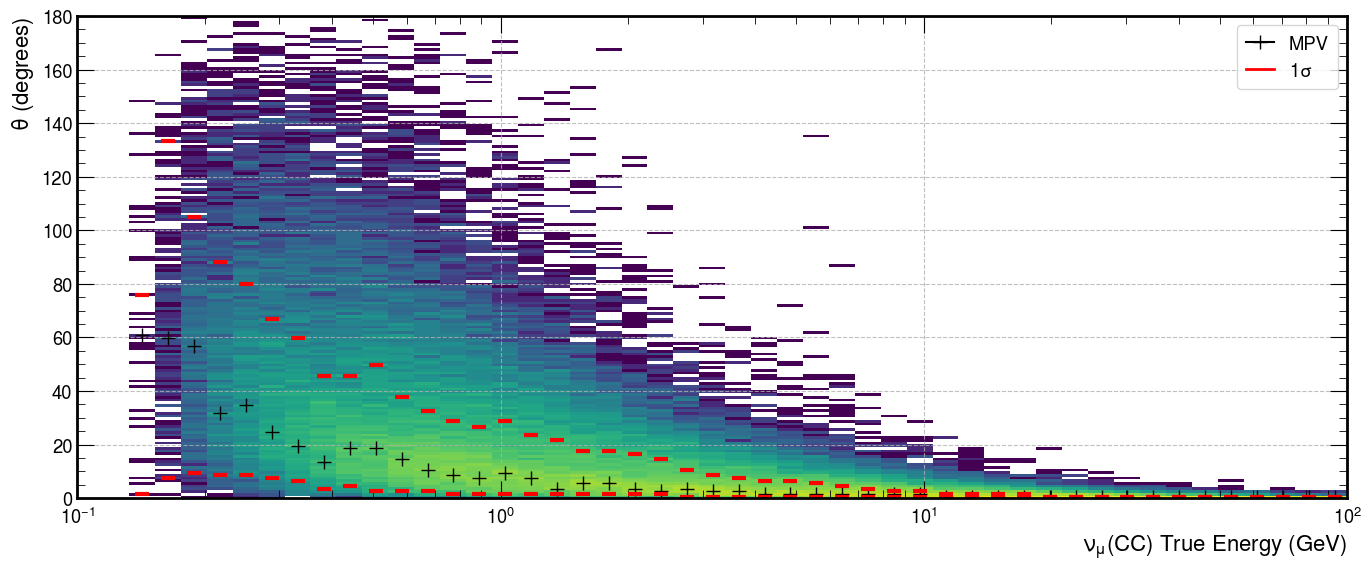

In [135]:
binsx=np.logspace(-1,2, 50)
binsy=np.linspace(0,180, 180)
plot_angle_vs_energy(q_all, binsx, binsy, 'angle_diff_s')


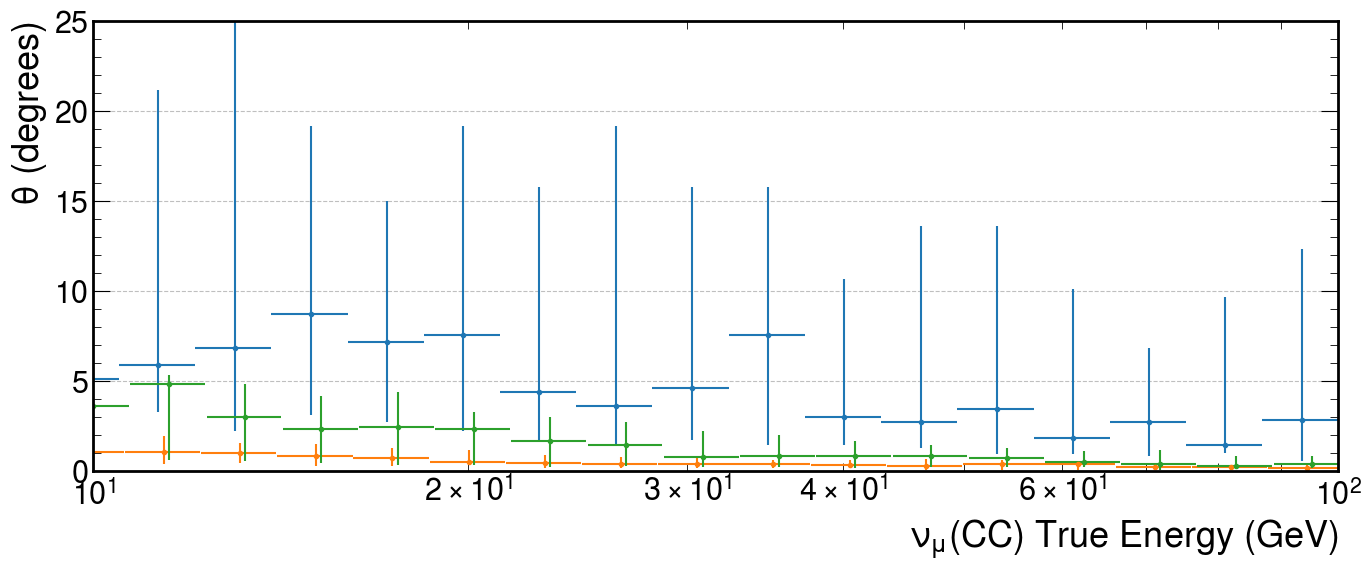

In [239]:

def plot_angle_vs_energy_cred(df:pl.DataFrame, binsx, binsy, angle_var, fmt, offset=0, **kwargs):
    global zoom
    if zoom:
        fontsize=26
    else:
        fontsize=16
    from scipy.stats import binned_statistic_2d

    H, edgex, edgey, binnumber = binned_statistic_2d(df['enu_truth'], df[angle_var],None,'count', bins=(binsx,binsy))
    edxwidth = (edgex[1:]-edgex[:-1])/2
    edywidth = (edgey[1:]-edgey[:-1])/2
    edxcenter = edgex[:-1] + edxwidth
    edycenter = edgey[:-1] + edywidth
    if 'label' in kwargs:
        label = kwargs.pop('label')
    else:
        label = ""
    for i in range(len(H)):
        if max(H[i,:]) > 1:
            hist_cred =  get1Dcred(H[i,:], 0.68)
            min_cred = 0
            max_cred = 0
            mode_cred = 0
            if len(hist_cred)!=0:
                min_cred = edycenter[min(hist_cred)]
                max_cred = edycenter[max(hist_cred)]
                mode_cred = edycenter[hist_cred[0]]

            plt.errorbar(edxcenter[i]+edxcenter[i]*offset, mode_cred, xerr=edxwidth[i], yerr=[ [mode_cred-min_cred], [max_cred-mode_cred] ], fmt=fmt, **kwargs)
        else:
            pass

    plt.xlabel(r'$\nu_\mu$(CC) True Energy (GeV)', fontsize=fontsize)
    plt.ylabel(r'$\theta$ (degrees)', fontsize=fontsize)
    plt.xscale('log')
    plt.ylim(0,180)
    if zoom:
        plt.ylim(0,25)
        plt.xlim(10,100)
        plt.tick_params(which='both',labelsize=fontsize-4)
zoom=True
plot_angle_vs_energy_cred(q, binsx, binsy, 'angle_diff', fmt='.', color='C0', offset=0)# capsize=5, capthick=2)
plot_angle_vs_energy_cred(q_all, binsx, binsy, 'angle_diff_t', fmt='.', color='C1',offset=0.01)# capsize=5, capthick=2)
plot_angle_vs_energy_cred(q_all, binsx, binsy, 'angle_diff_s', fmt='.', color='C2',offset=0.02)# capsize=5, capthick=2)
custom_label = [
    plt.Line2D([0],[0], marker="+", c='C0', label=r'Using $\mu$ only'),
    plt.Line2D([0],[0], marker="+", c='C1', label=r'Using all particles'),
    plt.Line2D([0],[0], marker="+", c='C2', label=r'Not using neutrons'),
    ]
# plt.legend(frameon=True, handles=custom_label)